## Dependencies

In [ ]:
import pandas as pd 
import numpy as np
from dotenv import load_dotenv
import os
import requests
from datetime import datetime, timedelta
import re
import pandas_ta as ta
import warnings
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots

pio.renderers.default = 'browser'
warnings.filterwarnings('ignore')

load_dotenv()

API_KEY = os.getenv('GLASSNODE_API_KEY')

## Fetching and Merging Raw Data

In [ ]:
# endpoints
# raw metrics 

SSR=os.getenv('SSR')
BTC_PRICE=os.getenv('BTC_PRICE')
SUPPLY_IN_PROFIT=os.getenv('SUPPLY_IN_PROFIT')
MVRV_Z_SCORE=os.getenv('MVRV_Z_SCORE')
BTC_REALIZED_PRICE=os.getenv('BTC_REALIZED_PRICE')
ENTITY_ADJ_NUPL=os.getenv('ENTITY_ADJ_NUPL')
PUELL_MULTIPLE=os.getenv('PUELL_MULTIPLE')
ENTITY_ADJ_DORMANCY_FLOW=os.getenv('ENTITY_ADJ_DORMANCY_FLOW')


In [ ]:
contextual_endpoints = [BTC_PRICE,BTC_REALIZED_PRICE,PUELL_MULTIPLE, MVRV_Z_SCORE, ENTITY_ADJ_NUPL, ENTITY_ADJ_DORMANCY_FLOW, SUPPLY_IN_PROFIT]
short_term_endpoints = [BTC_PRICE, SSR, SUPPLY_IN_PROFIT]

In [ ]:
def fetch_glassnode_data(endpoint, start, end, frequency):
    
    """
    Fetches data from the Glassnode API and returns it as a pandas DataFrame.

    Parameters:
    endpoint (str): The specific endpoint of the Glassnode API to fetch data from.
    start (str): The start date in 'YYYY-MM-DD' format.
    end (str): The end date in 'YYYY-MM-DD' format.
    frequency (str): The frequency interval for the data ('1h', '24h').

    Returns:
    pd.DataFrame: A DataFrame containing the fetched data with timestamps converted to datetime.
    
    Example:
    df = fetch_glassnode_data('indicators/sopr', '2021-01-01', '2021-01-02', '1h')
    print(df)

    Raises:
    ValueError: If the response from the API is not successful.
    """

    def _convert_to_unix_timestamp(date_str, date_format='%Y-%m-%d'):
        
        dt = datetime.strptime(date_str, date_format)
        return int(dt.timestamp())

    params = {
    'a': 'BTC',
    's': _convert_to_unix_timestamp(start),
    'u': _convert_to_unix_timestamp(end),
    'i': frequency,      
    'f': 'JSON'      
    }
    
    base_url = 'https://api.glassnode.com/v1/metrics'
    params['api_key'] = API_KEY
    url = f"{base_url}/{endpoint}"
    # Automate the name setting for the final dataframe column using ENDPOINT
    name = re.search(r'/([^/]*)$', endpoint).group(1)

    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        # Sucesso na requisição
        data = response.json()
        df = pd.DataFrame(data)
        # Converter colunas de data, se necessário
        if 't' in df.columns:
            df['t'] = pd.to_datetime(df['t'], unit='s')
        df.rename(columns={'v': name}, inplace=True)
        return df
    else:
        # Falha na requisição
        print(f"Erro: {response.status_code}")
        print(response.text)
        return None


In [ ]:
def fetch_and_merge_glassnode_data(endpoints, start, end, frequency):
    
    """
    Fetches data from multiple Glassnode API endpoints and merges them into a single DataFrame.

    Endpoints must have same frequency available, else, it will be dropped. 

    Parameters:
    endpoints (list of str): List of API endpoints to fetch data from.
    start (str): The start date in 'YYYY-MM-DD' format.
    end (str): The end date in 'YYYY-MM-DD' format.
    frequency (str): The frequency interval for the data ('1h', '24h').

    Returns:
    pd.DataFrame: A DataFrame containing the merged data from all endpoints, with timestamps aligned.

    Example:
    endpoints = [SSR, PUELL_MULTIPLE]
    df_merged = fetch_and_merge_glassnode_data(endpoints, '2021-01-01', '2021-01-02', '24h')
    print(df_merged)
    """

    # Initialize an empty list to collect DataFrames
    data_frames = []

    # Loop through each endpoint and fetch data
    for endpoint in endpoints:
        df = fetch_glassnode_data(endpoint, start, end, frequency)
        if df is not None and not df.empty:
            data_frames.append(df.set_index('t'))  # Use 't' as the index (common timestamp column)
        else:
            print(f"Failed to fetch data for endpoint: {endpoint}")

    # Merge all DataFrames on their indices (which are the timestamps)
    if data_frames:
        merged_df = pd.concat(data_frames, axis=1, join='outer')
    else:
        print("No data fetched successfully.")
        return None

    # Reset the index to make 't' a column again, if needed
    merged_df.reset_index(inplace=True)
    merged_df.set_index('t', inplace=True)

    return merged_df


# Indicator Calculations & Signal Generation

### Context Data

In [ ]:
context_data = fetch_and_merge_glassnode_data(endpoints=contextual_endpoints, start='201-01-01', end='2024-06-15', frequency='24h')

context_data['28d_mkt_gradient'] = (context_data['price_usd_close'].diff(28) - context_data['price_realized_usd'].diff(28) - (context_data['price_usd_close'].diff(28) - context_data['price_realized_usd'].diff(28)).mean()) / (context_data['price_usd_close'].diff(28) - context_data['price_realized_usd'].diff(28)).std()
context_data['mayer_multiple'] = context_data['price_usd_close'] / context_data['price_usd_close'].rolling(200).mean()
context_data['price_profit_corr'] = context_data['price_usd_close'].rolling(7).corr(context_data['profit_relative'])

context_data['top_detection'] = (np.where(context_data['mvrv_z_score'] > 3.8, 1, 0) * 
                                 np.where(context_data['mayer_multiple'] >= 1.3, 1, 0) *
                                 np.where(context_data['net_unrealized_profit_loss_account_based_pit'] >= 0.6, 1, 0) *
                                 np.where(context_data['28d_mkt_gradient'] >= 7, 1, 0)
                                 )

context_data['bottom_detection'] = (np.where(context_data['mvrv_z_score'] <= 0, 1, 0) * 
                                    np.where(context_data['mayer_multiple'] <= 0.8, 1, 0) *
                                    np.where(context_data['price_usd_close'] <= context_data['price_realized_usd'], 1, 0) *
                                    np.where(context_data['net_unrealized_profit_loss_account_based_pit'] <= 0, 1, 0) *
                                    np.where(context_data['puell_multiple'] <= 0.5, 1, 0) *
                                    np.where(context_data['dormancy_flow_pit'] <= 200000, 1, 0)
                                    )

# context_data.dropna(axis=0, inplace=True)
def determine_context(row):
    if row['bottom_detection'] != 0 and (row['top_detection'] == 0 or row.name < context_data.index[context_data['top_detection'] != 0].max()):
        return 'bull'
    elif row['top_detection'] != 0 and (row['bottom_detection'] == 0 or row.name < context_data.index[context_data['bottom_detection'] != 0].max()):
        return 'bear'
    else:
        return np.nan

# Apply the function to create the 'context' column
context_data['context'] = context_data.apply(determine_context, axis=1)

# Fill the NaN values based on the last valid observation to forward fill context where needed
context_data['context'].fillna(method='ffill', inplace=True)

context_data


### Trigger Data

In [ ]:
trigger_data = fetch_and_merge_glassnode_data(endpoints=short_term_endpoints, start='2021-01-01', end='2024-06-15', frequency='1h')


trigger_data['rsi_ssr_smoothed'] = ta.ema(ta.rsi(trigger_data['ssr_oscillator'], length=336),length=800)
trigger_data['rsi_ssr_smoothed_median'] = trigger_data['rsi_ssr_smoothed'].rolling(window=240).median()
trigger_data['pct_profit_mean'] = trigger_data['profit_relative'].mean()
trigger_data['pct_profit_sma30'] = trigger_data['profit_relative'].rolling(30*24).mean() 
trigger_data['pct_profit_sma360'] = trigger_data['profit_relative'].rolling(360*24).mean()
trigger_data['acc_dacc_pct_profit'] = trigger_data['pct_profit_sma30'].pct_change(30*24)

#trigger_data.dropna(axis=0, inplace=True)

trigger_data['ssr_buy_signal'] = np.where(trigger_data['rsi_ssr_smoothed_median'] < trigger_data['rsi_ssr_smoothed'], 1, 0)
trigger_data['ssr_sell_signal'] = np.where(trigger_data['rsi_ssr_smoothed_median'] > trigger_data['rsi_ssr_smoothed'], 1, 0)

# Generate buy signals (momentum changes from negative to positive)
trigger_data['profit_buy_signal'] = np.where((trigger_data['acc_dacc_pct_profit'].shift(1) <= 0) & (trigger_data['acc_dacc_pct_profit'] > trigger_data['acc_dacc_pct_profit'].shift(1)), 1, 0)

# Generate sell signals (momentum changes from positive to negative)
trigger_data['profit_sell_signal'] = np.where((trigger_data['acc_dacc_pct_profit'].shift(1) >= 0) & (trigger_data['acc_dacc_pct_profit'] < trigger_data['acc_dacc_pct_profit'].shift(1)), 1, 0)

trigger_data


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = trigger_data.copy()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)




data_scaled.describe()


In [ ]:
class DataManager:
    
    def __init__(self):
        self.api_key = os.getenv('GLASSNODE_API_KEY')

    @staticmethod
    def datetime_to_unix(date):
        """Convert a datetime object to a Unix timestamp."""
        return int(date.timestamp())

    def _fetch_glassnode_data(self, endpoint, start, end, frequency):
        params = {
            'a': 'BTC',
            's': self.datetime_to_unix(start),
            'u': self.datetime_to_unix(end),
            'i': frequency,
            'f': 'JSON',
            'api_key': self.api_key  
        }
        
        base_url = 'https://api.glassnode.com/v1/metrics'
        url = f"{base_url}/{endpoint}"
        name = re.search(r'/([^/]*)$', endpoint).group(1)

        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            df = pd.DataFrame(data)
            if 't' in df.columns:
                df['t'] = pd.to_datetime(df['t'], unit='s')
            df.rename(columns={'v': name}, inplace=True)
            return df
        else:
            raise Exception(f"Failed to fetch data: {response.status_code} - {response.text}")
    
    def _fetch_and_merge_glassnode_data(self, endpoints, start, end, frequency):
        data_frames = []

        for endpoint in endpoints:
            df = self._fetch_glassnode_data(endpoint, start, end, frequency)
            if df is not None and not df.empty:
                data_frames.append(df.set_index('t'))
            else:
                print(f"Failed to fetch data for endpoint: {endpoint}")

        if data_frames:
            merged_df = pd.concat(data_frames, axis=1, join='outer')
            merged_df.reset_index(inplace=True)
            merged_df.set_index('t', inplace=True)
            return merged_df
        else:
            return None
        
        
    
    def get_trigger_data(self, start, end, frequency='1h'):
        # Fetches data for the trigger points
        short_term_endpoints = [
            os.getenv('BTC_PRICE'),
            os.getenv('SSR'),
            os.getenv('SUPPLY_IN_PROFIT')
        ]
        return self._fetch_and_merge_glassnode_data(short_term_endpoints, start, end, frequency)

    def get_context_data(self, start, end, frequency='24h'):
        # Fetches data for context determination
        contextual_endpoints = [
            os.getenv('BTC_PRICE'),
            os.getenv('BTC_REALIZED_PRICE'),
            os.getenv('PUELL_MULTIPLE'),
            os.getenv('MVRV_Z_SCORE'),
            os.getenv('ENTITY_ADJ_NUPL'),
            os.getenv('ENTITY_ADJ_DORMANCY_FLOW'),
            os.getenv('SUPPLY_IN_PROFIT')
        ]
        return self._fetch_and_merge_glassnode_data(contextual_endpoints, start, end, frequency)
    
    


In [161]:
class TradingStrategy:

    def __init__(self, data_manager):
        self.data_manager = data_manager

    def compute_triggers(self, start, end):
        
        start = datetime.strptime(start, '%Y-%m-%d')
        end = datetime.strptime(end, '%Y-%m-%d')
        
        trigger_data = self.data_manager.get_trigger_data((start - timedelta(hours=8640)), end)
        
        trigger_data['rsi_ssr_smoothed'] = ta.ema(ta.rsi(trigger_data['ssr_oscillator'], length=336), length=800)
        trigger_data['rsi_ssr_smoothed_median'] = trigger_data['rsi_ssr_smoothed'].rolling(window=240).median()
        #trigger_data['pct_profit_mean'] = trigger_data['profit_relative'].expanding().mean()
        trigger_data['pct_profit_sma30'] = trigger_data['profit_relative'].rolling(30 * 24).mean()
        #trigger_data['pct_profit_sma360'] = trigger_data['profit_relative'].rolling(360 * 24).mean()
        trigger_data['acc_dacc_pct_profit'] = trigger_data['pct_profit_sma30'].pct_change(30 * 24)
        
        # Signal calculation
        trigger_data['ssr_buy_signal'] = np.where(trigger_data['rsi_ssr_smoothed_median'] < trigger_data['rsi_ssr_smoothed'], 1, 0)
        trigger_data['ssr_sell_signal'] = np.where(trigger_data['rsi_ssr_smoothed_median'] > trigger_data['rsi_ssr_smoothed'], 1, 0)
        trigger_data['profit_buy_signal'] = np.where(
            (trigger_data['acc_dacc_pct_profit'].shift(1) <= 0) & (trigger_data['acc_dacc_pct_profit'] > trigger_data['acc_dacc_pct_profit'].shift(1)), 1, 0)
        trigger_data['profit_sell_signal'] = np.where(
            (trigger_data['acc_dacc_pct_profit'].shift(1) >= 0) & (trigger_data['acc_dacc_pct_profit'] < trigger_data['acc_dacc_pct_profit'].shift(1)), 1, 0)
        
        trigger_data = trigger_data[trigger_data.index >= start]
        
        return trigger_data

    def compute_context(self, start, end):

        start = datetime.strptime(start, '%Y-%m-%d')
        end = datetime.strptime(end, '%Y-%m-%d')
        
        context_data = self.data_manager.get_context_data((start - timedelta(days=360)), end)

        # Market condition calculations
        context_data['28d_mkt_gradient'] = (context_data['price_usd_close'].diff(28) - context_data['price_realized_usd'].diff(28) - 
                                            (context_data['price_usd_close'].diff(28) - context_data['price_realized_usd'].diff(28)).expanding().mean()) / \
                                            (context_data['price_usd_close'].diff(28) - context_data['price_realized_usd'].diff(28)).expanding().std()
        
        
        context_data['mayer_multiple'] = context_data['price_usd_close'] / context_data['price_usd_close'].rolling(200).mean()
        context_data['price_profit_corr'] = context_data['price_usd_close'].rolling(7).corr(context_data['profit_relative'])

    

        # Detect market tops and bottoms
        context_data['top_detection'] = (np.where(context_data['mvrv_z_score'] > 3.8, 1, 0) * 
                                         np.where(context_data['mayer_multiple'] >= 1.3, 1, 0) *
                                         np.where(context_data['net_unrealized_profit_loss_account_based'] >= 0.6, 1, 0) *
                                         np.where(context_data['28d_mkt_gradient'] >= 7, 1, 0))
        
        context_data['bottom_detection'] = (np.where(context_data['mvrv_z_score'] <= 0, 1, 0) * 
                                            np.where(context_data['mayer_multiple'] <= 0.8, 1, 0) *
                                            np.where(context_data['price_usd_close'] <= context_data['price_realized_usd'], 1, 0) *
                                            np.where(context_data['net_unrealized_profit_loss_account_based'] <= 0, 1, 0) *
                                            np.where(context_data['puell_multiple'] <= 0.5, 1, 0) *
                                            np.where(context_data['dormancy_flow'] <= 200000, 1, 0))

       

        # Apply context determination
        context_data['context'] = context_data.apply(self.determine_context, axis=1)
        context_data['context'].fillna(method='ffill', inplace=True)
        context_data = context_data[context_data.index >= start]
        
        return context_data

    @staticmethod
    def determine_context(row):
        if row['bottom_detection'] != 0 and (row['top_detection'] == 0 or row.name < row.index[row['top_detection'] != 0].max()):
            return 'bull'
        elif row['top_detection'] != 0 and (row['bottom_detection'] == 0 or row.name < row.index[row['bottom_detection'] != 0].max()):
            return 'bear'
        else:
            return np.nan
        
    def generate_signals(self, trigger_data, context_data):
        
        full_data=pd.merge_asof(trigger_data, context_data['context'], on='t', direction='forward')
        
        full_data['context'] = full_data['context'].ffill()
        full_data

        # Initialize the action column
        full_data['action'] = 'cash'  # Default action is to cash
        full_data.loc[(full_data['context'] == 'bull') & (full_data['ssr_buy_signal'] == 1), 'action'] = 'long'
        full_data.loc[(full_data['context'] == 'bull') & ((full_data['ssr_sell_signal'] == 1)), 'action'] = 'cash'
        full_data.loc[(full_data['context'] == 'bear') & ((full_data['ssr_sell_signal'] == 1)), 'action'] = 'short'
        full_data.loc[(full_data['context'] == 'bear'), 'action'] = 'cash'

        full_data.set_index('t', inplace=True)

        return full_data




In [166]:
class Backtester:
    
    def __init__(self, data, initial_capital=10000):
        self.data = data
        self.initial_capital = initial_capital
        self.results = {}
        self.run_backtest()

    def run_backtest(self):
        self.data['position'] = self.data['action'].map({'long': 1, 'short': -1, 'cash': 0}).fillna(0)
        self.data['market_return'] = self.data['price_usd_close'].pct_change()
        self.data['strategy_return'] = self.data['position'].shift(1) * self.data['market_return']
        self.data['strategy_cumulative_return'] = (1 + self.data['strategy_return']).cumprod() * self.initial_capital
        self.data['strategy_cumulative_return'].fillna(self.initial_capital, inplace=True)
        self.calculate_statistics()

    def calculate_statistics(self):
        self.results['Start'] = self.data.index.min()
        self.results['End'] = self.data.index.max()
        self.results['Duração'] = self.results['End'] - self.results['Start']
        self.results['Tempo de Exposição [%]'] = np.mean(self.data['position'] != 0) * 100
        self.results['Saldo Final [$]'] = self.data['strategy_cumulative_return'].iloc[-1]
        self.results['Pico de Valor [$]'] = self.data['strategy_cumulative_return'].max()
        self.results['Retorno AlfaTrader [%]'] = ((self.results['Saldo Final [$]'] / self.initial_capital - 1) * 100)
        self.results['Retorno Buy & Hold [%]'] = ((self.data['price_usd_close'].iloc[-1] / self.data['price_usd_close'].iloc[0] - 1) * 100)
        self.results['Retorno (Ann.) [%]'] = self.results['Retorno AlfaTrader [%]'] / (self.results['Duração'].days / 365.25)
        self.results['Volatilidade (Ann.) [%]'] = self.data['strategy_return'].std() * np.sqrt(365*24) * 100

        # Filter to include only non-zero returns or when the strategy is active
        active_returns = self.data['strategy_return'][self.data['strategy_return'] != 0]

        # Calculate Sharpe Ratio using non-zero returns
        if active_returns.empty:
            self.results['Sharpe Ratio'] = 0  # Handle case where there are no active returns
        else:
            self.results['Sharpe Ratio'] = (active_returns.mean() / self.data['strategy_return'].std()) * np.sqrt(8760)

        # Calculate negative returns for the downside deviation
        negative_returns = self.data['strategy_return'][self.data['strategy_return'] < 0]

        # Calculate Sortino Ratio using non-zero returns and downside deviation
        if not negative_returns.empty and not active_returns.empty:
            mean_active_returns = active_returns.mean()
            downside_deviation = negative_returns.std()
            annual_factor = np.sqrt(8760)  # Assuming 24/7 trading for crypto markets
            self.results['Sortino Ratio'] = (mean_active_returns / downside_deviation) * annual_factor
        else:
            self.results['Sortino Ratio'] = 0  # Handle case where there are no negative returns or active returns

        # Drawdown calculations
        drawdown = self.data['strategy_cumulative_return'].cummax() - self.data['strategy_cumulative_return']
        drawdown_pct = drawdown / self.data['strategy_cumulative_return'].cummax() * 100
        
        #self.results['Max. Drawdown [%]'] = drawdown_pct.min()
        #self.results['Drawdown Médio [%]'] = drawdown_pct.mean()

        #self.results['Max. Drawdown Duration'] = drawdown[drawdown == 0].astype(int).groupby((drawdown != 0).cumsum()).cumcount().max()
        #self.results['Avg. Drawdown Duration'] = drawdown[drawdown == 0].astype(int).groupby((drawdown != 0).cumsum()).cumcount().mean()

        # Trading statistics
        trades = self.data['position'].diff().fillna(0) != 0
        self.results['# Trades'] = trades.sum()
        #winning_trades = self.data['strategy_return'][trades] > 0
        #self.results['Win Rate [%]'] = winning_trades.mean() * 100
        #self.results['Best Trade [%]'] = self.data['strategy_return'][winning_trades].max() * 100
        #self.results['Worst Trade [%]'] = self.data['strategy_return'][trades].min() * 100
        #self.results['Avg. Trade [%]'] = self.data['strategy_return'][trades].mean() * 100
        #self.results['Max. Trade Duration'] = trades.groupby((trades == 0).cumsum()).cumcount().max()
        #self.results['Avg. Trade Duration'] = trades.groupby((trades == 0).cumsum()).cumcount().mean()

    def get_results(self):
        return pd.DataFrame([self.results])

In [167]:
class StrategyVisualizer:
    def __init__(self, data):
        self.data = data

    def plot_results(self):
        # Create subplots: one for portfolio values and one for BTC price with signals
        fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                            vertical_spacing=0.1, subplot_titles=('Valor do Portfólio', 'Preço BTC com Sinais'))

        # Plotting portfolio values: Strategy vs Buy & Hold
        fig.add_trace(go.Scatter(x=self.data.index, y=self.data['strategy_cumulative_return'], name='Retorno Cumulativo da Estratégia', line=dict(color='green')), row=1, col=1)
        fig.add_trace(go.Scatter(x=self.data.index, y=self.data['price_usd_close'], name='Comprar e Manter', line=dict(color='blue')), row=1, col=1)

        # BTC Price and action markers
        fig.add_trace(go.Scatter(x=self.data.index, y=self.data['price_usd_close'], name='Preço BTC', line=dict(color='black')), row=2, col=1)

        # Adding markers only at points of action change
        action_changes = self.data[self.data['action'] != self.data['action'].shift(1)]
        buys = action_changes[action_changes['action'] == 'long']
        cash = action_changes[action_changes['action'] == 'cash']
        shorts = action_changes[action_changes['action'] == 'short']

        print(shorts)

        fig.add_trace(go.Scatter(x=buys.index, y=buys['price_usd_close'], mode='markers', marker=dict(color='green', size=10, symbol='triangle-up'), name='Compra'), row=2, col=1)
        fig.add_trace(go.Scatter(x=cash.index, y=cash['price_usd_close'], mode='markers', marker=dict(color='gray', size=10, symbol='square'), name='Caixa'), row=2, col=1)
        fig.add_trace(go.Scatter(x=shorts.index, y=shorts['price_usd_close'], mode='markers', marker=dict(color='red', size=10, symbol='triangle-down'), name='Venda'), row=2, col=1)

        # Update layout
        fig.update_layout(height=800, width=1000, title_text="Análise Estratégica Abrangente", hovermode="x unified", plot_bgcolor='white', paper_bgcolor='white', font=dict(color='black'))
        fig.show()




In [162]:
# USAGE
data_manager=DataManager()
strategy = TradingStrategy(data_manager=data_manager)
context_data = strategy.compute_context('2011-08-1', '2024-06-18')
trigger_data = strategy.compute_triggers('2020-12-01', '2024-6-18')
final_data = strategy.generate_signals(trigger_data, context_data)


<Axes: >

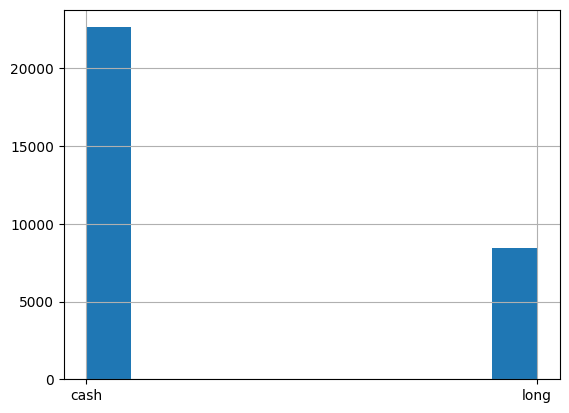

In [170]:
final_data['action'].hist()

In [168]:
backtester = Backtester(final_data)
results = backtester.get_results().T
results

,0
Start,2020-12-01 00:00:00
End,2024-06-18 02:00:00
Duração,1295 days 02:00:00
Tempo de Exposição [%],27.130586
Saldo Final [$],26830.077337
Pico de Valor [$],29040.368877
Retorno AlfaTrader [%],168.300773
Retorno Buy & Hold [%],235.811334
Retorno (Ann.) [%],47.468616
Volatilidade (Ann.) [%],25.555807


In [169]:
visualizer = StrategyVisualizer(final_data)
visualizer.plot_results()
#visualizer.calculate_rolling_metrics()


Empty DataFrame
Columns: [price_usd_close, ssr_oscillator, profit_relative, rsi_ssr_smoothed, rsi_ssr_smoothed_median, pct_profit_sma30, acc_dacc_pct_profit, ssr_buy_signal, ssr_sell_signal, profit_buy_signal, profit_sell_signal, context, action, position, market_return, strategy_return, strategy_cumulative_return]
Index: []
